# Airfoil analysis

This is a small demonstration in how to use the 
[neuralfoil](https://github.com/peterdsharpe/NeuralFoil) lib. 

As described in its github repository:

> NeuralFoil is a tool for rapid aerodynamics analysis of airfoils, similar to XFoil. Under the hood, NeuralFoil consists of physics-informed neural networks trained on tens of millions of XFoil runs.

The advantage of neuralfoil is its fast result (see benchmark for comparison with other methods). Can be useful when iterating over many variations in an optimizer.

## Load airfoil

Aerosandbox already has a big dataset of airfoils, so we just need to call the name of one of them. 
We can also plot its coordinates.

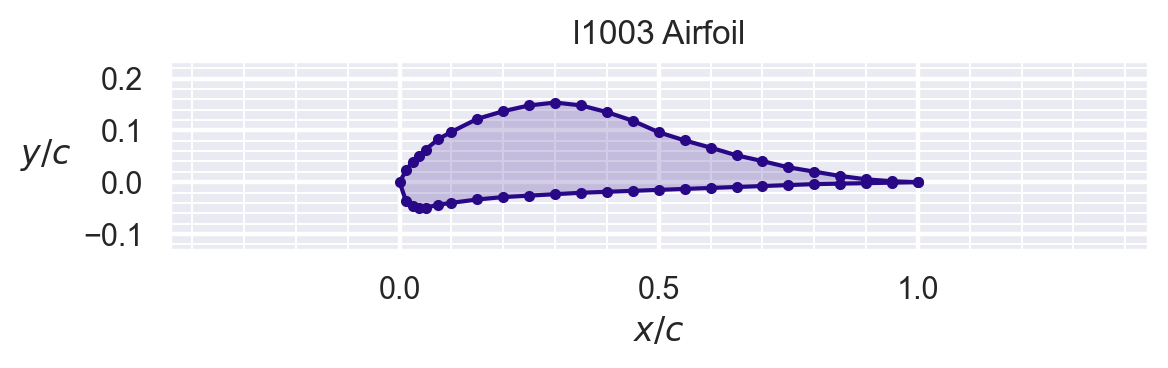

In [1]:
import aerosandbox as asb
import aerosandbox.numpy as np
import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p
from matplotlib.colors import LinearSegmentedColormap
from aerosandbox.tools.string_formatting import eng_string

# Load airfoil
af = asb.Airfoil("l1003")

fig, ax = plt.subplots(figsize=(6, 2))
af.draw()

## Get aerodynamic coefficients

To run the neuralfoil just call `get_aero_from_neuralfoil()`. You can define a range of alpha and Reynolds to run the simulation. The `xxxlarge` parameters means we are using a more precise (but slower) neural network.

In [2]:
alpha = np.linspace(-10, 20, 181)
re = np.geomspace(1e5, 1e6, 5)

Alpha, Re = np.meshgrid(alpha, re)

aero_flattened = af.get_aero_from_neuralfoil(
    alpha=Alpha.flatten(),
    Re=Re.flatten(),
    mach=0,
    model_size="xxxlarge",
)
Aero = {
    key: value.reshape(Alpha.shape)
    for key, value in aero_flattened.items()
}

## Plot results

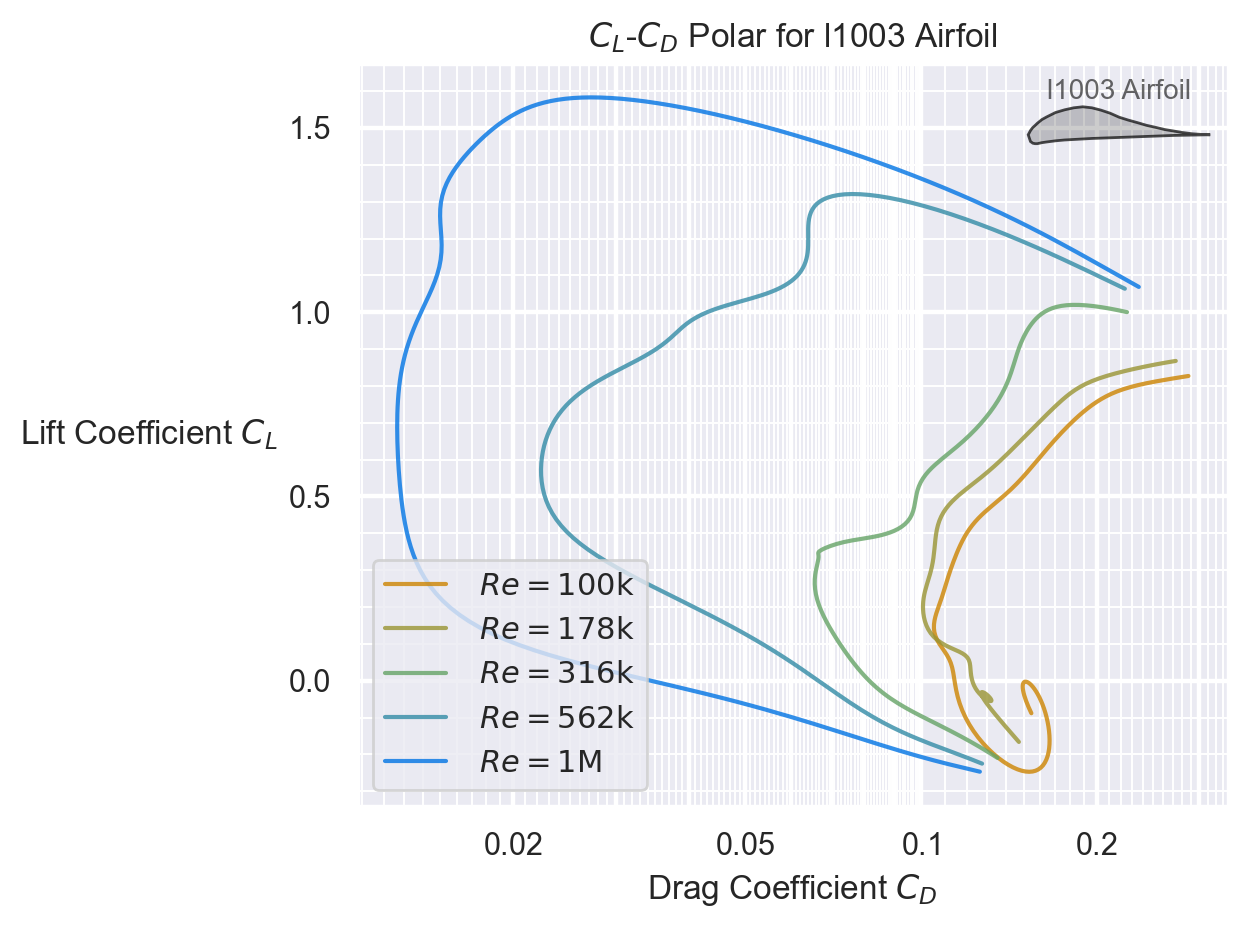

In [3]:
fig, ax = plt.subplots()
colors = LinearSegmentedColormap.from_list(
    "custom_cmap",
    colors=[
        p.adjust_lightness(c, 0.8) for c in
        ["orange", "darkseagreen", "dodgerblue"]
    ]
)(np.linspace(0, 1, len(re)))

for i in range(len(re)):
    line, = ax.plot(
        Aero["CD"][i, :],
        Aero["CL"][i, :],
        color=colors[i], alpha=0.8,
        label=f" $Re = \\mathrm{{{eng_string(re[i])}}}$"
    )

afax = ax.inset_axes([0.76, 0.802, 0.23, 0.23])
afax.fill(
    af.x(), af.y(),
    facecolor=(0, 0, 0, 0.2), linewidth=1, edgecolor=(0, 0, 0, 0.7)
)
afax.annotate(
    text=f"{af.name} Airfoil\n",
    xy=(0.5, 0),
    ha="center", va="bottom", fontsize=10,
    alpha=0.7
)
afax.axis('off')
afax.axis('equal')

plt.xscale('log')
p.show_plot(
    title=f"$C_L$-$C_D$ Polar for {af.name} Airfoil",
    xlabel="Drag Coefficient $C_D$",
    ylabel="Lift Coefficient $C_L$",
)

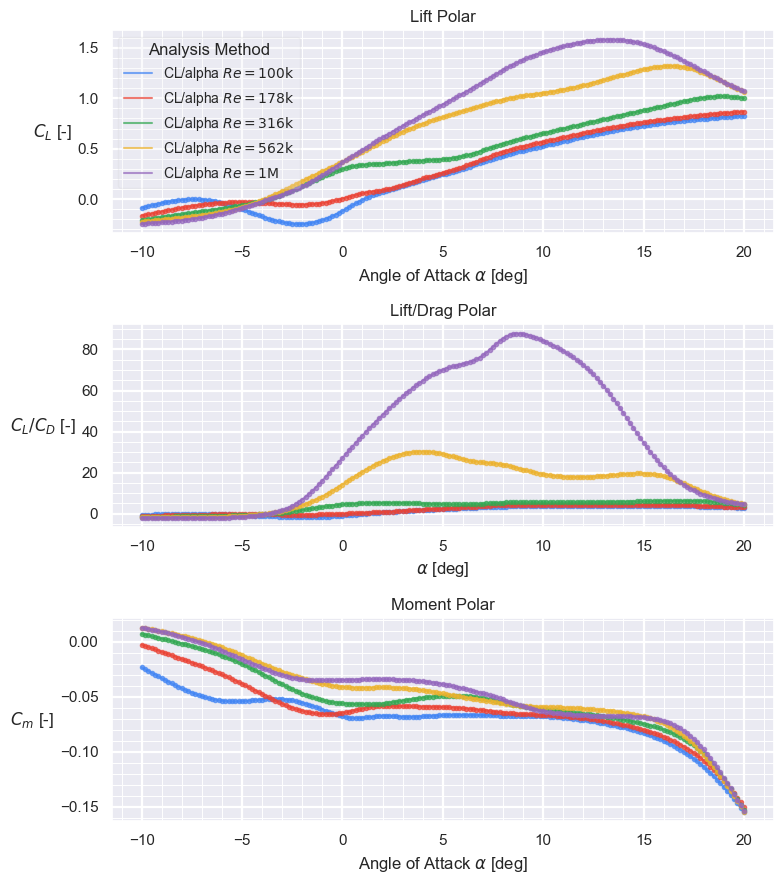

In [4]:
Aero["CL/CD"] = np.divide(Aero["CL"], Aero["CD"])
fig, ax = plt.subplots(3, 1, figsize=(8, 9), dpi=100)

for i in range(len(re)):
    plt.sca(ax[0])
    p.plot_smooth(
        Alpha[i, :],
        Aero["CL"][i, :],
        label=f"CL/alpha $Re = \\mathrm{{{eng_string(re[i])}}}$",
        function_of="x",
        alpha=0.7,
    )

    plt.sca(ax[1])
    p.plot_smooth(
        Alpha[i, :],
        Aero["CL/CD"][i, :],
        label=f"CD/CL $Re = \\mathrm{{{eng_string(re[i])}}}$",
        function_of="x",
        alpha=0.7,
    )

    plt.sca(ax[2])
    p.plot_smooth(
        Alpha[i, :],
        Aero["CM"][i, :],
        label=f"CM/alpha $Re = \\mathrm{{{eng_string(re[i])}}}$",
        function_of="x",
        alpha=0.7,
    )


ax[0].set_title("Lift Polar")
ax[0].set_xlabel("Angle of Attack $\\alpha$ [deg]")
ax[0].set_ylabel("$C_L$ [-]")

ax[1].set_title("Lift/Drag Polar")
ax[1].set_xlabel("$\\alpha$ [deg]")
ax[1].set_ylabel("$C_L/C_D$ [-]")

ax[2].set_title("Moment Polar")
ax[2].set_xlabel("Angle of Attack $\\alpha$ [deg]")
ax[2].set_ylabel("$C_m$ [-]")
# ax[2].set_ylim(top=0)  # Keep zero in view

ax[0].legend(
    title="Analysis Method",
    fontsize=10,
    framealpha=0.2,
)
p.show_plot(legend=False)